# 0. Preamble

## 0.1. Imports

In [1]:
# utils
import os, gc
import numpy as np
import pandas as pd 
from functools import partial, update_wrapper
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphviz import Digraph
import gc

# sklearn
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import FastICA

# tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.sequence import pad_sequences

# scipy
from scipy.signal import welch, spectrogram, butter, filtfilt, hilbert
from scipy import signal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.2. Configs

In [2]:
class CFG:
    # debug mode
    debug = False
    
    # parallel
    num_workers = -1
    
    # dataset
    competition_name = "tlvmc-parkinsons-freezing-gait-prediction"
    target_cols = ["StartHesitation", "Turn", "Walking"]
    seq_len = 5000
    shift = 2500
    offset = 1250
    input_dir = Path("../input/") / competition_name
    output_dir = Path("./")

## 0.3. Utils

In [3]:
def get_filename_no_ext(file_path):
    """
    Extracts the filename without extension from the given file path.

    Args:
    - file_path: str or Path
        The file path from which the filename without extension will be extracted.

    Returns:
    - filename: str
        The filename without extension.

    Raises:
    - ValueError: If the input file_path is not a string or Path object.

    Example:
    >>> get_filename_no_ext('/path/to/file.txt')
    'file'
    >>> get_filename_no_ext(Path('/path/to/file.txt'))
    'file'
    """
    if isinstance(file_path, str):
        base = os.path.basename(file_path)
    elif isinstance(file_path, Path):
        base = file_path.name
    else:
        raise ValueError("Unsupported file path type. Please provide a string or PosixPath object.")
    
    filename = os.path.splitext(base)[0]
    return filename


def _cartesian_to_spherical(x, y, z):
    '''
    Given a 3D vector in cartesian coordinates, convert to spherical coordinates

    Args:
        x, y, z: float
            x, y, z coordinates of the vector
    
    Returns:
        r, theta, phi: float
    '''
    r = np.sqrt(x**2 + y**2 + z**2)  # Radial distance
    if r == 0:
        theta = 0  # Avoid division by zero
    else:
        theta = np.arccos(z / r)  # Polar angle
    phi = np.arctan2(y, x)  # Azimuth angle
    return r, theta, phi


def cartesian_to_spherical(data):
    '''
    Given a 2D array of (3, n_timepoints) in cartesian coordinates, 
    convert cartesian coordinates to spherical coordinates.

    Args:
        data: numpy array
            2D array of (3, n_timepoints) in cartesian coordinates

    Returns:
        r, theta, phi: numpy array
            2D array of (3, n_timepoints) in spherical coordinates
    '''
    r, theta, phi = np.apply_along_axis(lambda m: _cartesian_to_spherical(*m), 
                                        axis=0, arr=data)
    return np.vstack((r, theta, phi))


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''
    Perform bandpass filtering on a 2D array of (n_channels, n_timepoints).

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)
        lowcut: float
            Lower cutoff frequency
        highcut: float
            Upper cutoff frequency
        fs: float
            Sampling frequency
        order: int
            Order of the filter
    
    Returns:
        data: numpy array of (n_channels, n_timepoints)
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Get the filter coefficients
    b, a = signal.butter(order, [low, high], btype='band')
    data = np.apply_along_axis(lambda m: signal.lfilter(b, a, m), axis=1, arr=data)
    return data


def moving_average(data, window_size):
    '''
    Perform moving average on a 2D array of (n_channels, n_timepoints).

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)
        window_size: int
            Size of the moving average window

    Returns:
        data: numpy array of (n_channels, n_timepoints)
    '''
    kernel = np.ones(window_size) / window_size
    data = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), 
                               axis=1, arr=data)
    return data


def window_sinc_convolve(data, window_size, fs):
    '''
    Perform windowed sinc convolution on a 2D array of (n_channels, n_timepoints).

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)
        window_size: int
            Size of the window
        fs: float
            Sampling frequency

    Returns:
        data: numpy array of (n_channels, n_timepoints)
    '''
    kernel = np.sinc(2 * window_size * np.arange(fs) / fs)
    data = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), 
                               axis=1, arr=data)
    return data


def acceleration_to_velocity(data, fs):
    '''
    Given a 2D array of (n_channels, n_timepoints) in acceleration, 
    convert to velocity.

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints) in acceleration
        fs: float
            Sampling frequency

    Returns:
        data: numpy array of (n_channels, n_timepoints) in velocity
    '''
    data = np.apply_along_axis(lambda m: np.cumsum(m) / fs, axis=1, arr=data)
    return data


def normalize(data):
    '''
    Given a 2D array of (n_channels, n_timepoints), normalize each channel.

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)

    Returns:
        data: numpy array of (n_channels, n_timepoints)
    '''
    data = np.apply_along_axis(lambda m: (m - np.mean(m)) / np.std(m), axis=1, arr=data)
    return data


def hilbert_transform(data):
    '''
    Given a 2D array of (n_channels, n_timepoints), perform hilbert transform 
    on each channel and return 2 arrays of (n_channels, n_timepoints) for
    amplitude and phase.

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)

    Returns:
        amplitude: numpy array of (n_channels, n_timepoints)
        phase: numpy array of (n_channels, n_timepoints)
    '''
    hilbert_transformed = np.apply_along_axis(lambda m: hilbert(m), axis=1, arr=data)
    amplitude = np.abs(hilbert_transformed)
    phase = np.angle(hilbert_transformed)
    return amplitude, phase


def spectrogram(data, fs, nperseg=128, noverlap=64, max_freq=50, min_freq=0):
    '''
    Given a 2D array of (n_channels, n_timepoints), perform STFT on each channel
    and return an array of frequencies, an array of time points, and a 3D array 
    of (n_channels, n_freqs, n_timepoints).

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)
        fs: float
            Sampling frequency
        nperseg: int
            Length of each segment
        noverlap: int
            Number of points to overlap between segments
        max_freq: float
            Maximum frequency to return
        min_freq: float
            Minimum frequency to return

    Returns:
        frequencies: numpy array of (n_freqs,)
        timepoints: numpy array of (n_timepoints,)
        spectrogram: numpy array of (n_channels, n_freqs, n_timepoints)
    '''
    frequencies, timepoints, spectrogram = signal.spectrogram(data, fs=fs, 
                                                              nperseg=nperseg, 
                                                              noverlap=noverlap)
    # Remove frequencies above max_freq and below min_freq
    frequencies = frequencies[(frequencies <= max_freq) & (frequencies >= min_freq)]
    spectrogram = spectrogram[:, (frequencies <= max_freq) & (frequencies >= min_freq), :]
    return frequencies, timepoints, spectrogram


def noise_remove_ica(data, n_components=3):
    '''
    Given a 2D array of (n_channels, n_timepoints), perform ICA to remove noise.

    Args:
        data: numpy array
            2D array of (n_channels, n_timepoints)
        n_components: int
            Number of components to keep

    Returns:
        data: numpy array of (n_channels, n_timepoints)
    '''
    ica = FastICA(n_components=n_components)
    data = ica.fit_transform(data.T).T
    return data


def generate_shorter_sequences(long_x, long_y, window_size, stride):
    '''
    Generates shorter sequences from longer input sequences.

    Args:
        long_x: A numpy array representing the long input sequences with shape (n_samples, n_features).
        long_y: A numpy array representing the corresponding long target sequences with shape (n_samples, n_targets).
        window_size: An integer specifying the size of the shorter sequences to be generated.
        stride: An integer specifying the stride or step size along the long sequences.

    Yields:
        A generator that produces tuples of shorter input and target sequences.

    Example:
        # Generate shorter sequences with window size 5 and stride 2
        long_input = np.array([[1, 2, 3, 4, 5],
                               [6, 7, 8, 9, 10],
                               [11, 12, 13, 14, 15]])
        long_target = np.array([[0, 1],
                                [1, 0],
                                [0, 1]])
        for short_x, short_y in generate_shorter_sequences(long_input, long_target, window_size=3, stride=2):
            print("Short Input:", short_x)
            print("Short Target:", short_y)
    '''
    seq_len = long_x.shape[0]
    for i in range(0, long_x.shape[0] - window_size + 1, stride):
        yield long_x[i:i+window_size, :], long_y[i:i+window_size, :]
    if (seq_len % window_size) % stride > 0 :
        yield long_x[-window_size:, :], long_y[-window_size:, :]
    

def plot_spectrogram(X, fs, maxfreq=5, minfreq=0, nperseg=512, ax=None, figsize=(12, 4)):
    """
    Plots the spectrogram of a signal.

    Args:
    - X (array_like): The input signal.
    - fs (float): The sampling frequency of the signal.
    - maxfreq (float, optional): Maximum frequency to display in the spectrogram.
    Default is 5 Hz.
    - minfreq (float, optional): Minimum frequency to display in the spectrogram.
    Default is 0 Hz.
    - nperseg (int, optional): Length of each segment used to compute the FFT.
    Default is 512.
    - ax (matplotlib.axes.Axes, optional): The Axes object to plot on. If None,
    a new figure will be created.
    - figsize (tuple, optional): Figure size (width, height) in inches.
    Default is (12, 4).

    Return: None
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    f, t, Sxx = spectrogram(X, fs)
    ax.pcolormesh(t, f, Sxx, cmap='magma')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(minfreq, maxfreq)
    
    
class WrappedPartial:
    """
    A class representing a wrapped partial function.

    Parameters:
    - original_func (callable): The original function to create a partial function from.
    - *args: Positional arguments to fix in the partial function.
    - **kwargs: Keyword arguments to fix in the partial function.
    """

    def __init__(self, original_func, *args, **kwargs):
        """
        Initialize a WrappedPartial instance.

        Parameters:
        - original_func (callable): The original function to create a partial function from.
        - *args: Positional arguments to fix in the partial function.
        - **kwargs: Keyword arguments to fix in the partial function.
        """
        partial_func = partial(original_func, *args, **kwargs)

        # Preserve __doc__ and __name__ attributes
        update_wrapper(partial_func, original_func)
        self.partial_func = partial_func

    def getfunc(self, new_name=None):
        """
        Get the partial function.

        Parameters:
        - new_name (str, optional): If provided, set the __name__ attribute of the partial function to this value.

        Returns:
        - callable: The partial function.
        """
        partial_func = self.partial_func
        if new_name is not None:
            partial_func.__name__ = new_name
        return partial_func 
    
    
    
class FunctionNode:
    """
    A class representing a node associated with a function.

    Parameters:
    - func (callable): The function associated with the root node.
    - children (list, optional): List of child nodes. Defaults to an empty list.
    """

    def __init__(self, func, children=None):
        """
        Initialize a FunctionTree instance.

        Parameters:
        - func (callable): The function associated with the root node.
        - children (list, optional): List of child nodes. Defaults to an empty list.
        """
        self.func = func
        self.children = children or []

    def add_child(self, child_node):
        """
        Add a child node to the root node.

        Parameters:
        - child_node (FunctionTree): The child node to be added.
        """
        self.children.append(FunctionNode(child_node))

    def find_node(self, target_func):
        """
        Recursively search for a node with a specific function in the tree.

        Parameters:
        - target_func (callable): The target function to search for.

        Returns:
        - FunctionTree or None: The node with the target function, or None if not found.
        """
        if self.func == target_func:
            return self
        else:
            for child in self.children:
                found_node = child.find_node(target_func)
                if found_node:
                    return found_node
        return None

    def add_child_to_node(self, target_func, new_child):
        """
        Add a child node to an arbitrary node in the tree.

        Parameters:
        - target_func (callable): The function associated with the target node.
        - new_child (FunctionTree): The child node to be added to the target node.
        """
        target_node = self.find_node(target_func)
        if target_node:
            target_node.add_child(new_child)
        else:
            print(f"Node with function {target_func} not found.")

    def _evaluate(self, input_value):
        """
        Recursively evaluate the tree and return a list of outputs from all leaf nodes.

        Parameters:
        - input_value: The input value to be used in the function evaluations.

        Returns:
        - list: A list of outputs from all leaf nodes.
        """
        if not self.children:
            return self.func(input_value), 
        else:
            curr_result = self.func(input_value)
            child_results = [child.evaluate(curr_result) for child in self.children]
            
            return  [result for sublist in child_results for result in sublist]
        
    def evaluate(self, input_value):
        """
        Evaluate the tree and return a list of outputs from all leaf nodes.

        Parameters:
        - input_value: The input value to be used in the function evaluations.

        Returns:
        - numpy.ndarray: A numpy array stacking all data produced from the leaf nodes on axis 0.
        The resulting shape is (n_leaves, ...).
        """
        results = self._evaluate(input_value)
        return np.array(results)
        

    def visualize(self, graph=None, parent_name=None, graphviz=None, size=None):
        """
        Generate a graphical representation of the tree using Graphviz.

        Parameters:
        - graph (Digraph, optional): The Graphviz graph. Defaults to None.
        - parent_name (str, optional): The name of the parent node. Defaults to None.
        - graphviz (Digraph, optional): The original Graphviz graph. Defaults to None.
        - size (tuple, optional): The size of the output graph. Defaults to None.

        Returns:
        - Digraph: The Graphviz graph.
        """
        if graph is None:
            graph = Digraph(format='png')

            # Set the size if provided
            if size:
                graph.attr(size=size)

            graphviz = graph
        current_name = str(id(self))
        graph.node(current_name, label=str(self.func.__name__))

        if parent_name is not None:
            graph.edge(parent_name, current_name)

        for i, child in enumerate(self.children):
            child.visualize(graph, current_name, graphviz=graphviz, size=size)

        return graph
    
    



## 0.4. LSTM models

### 0.4.1. Residual LSTM

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

class ResidualLSTM(tf.keras.Model):
    def __init__(self, num_layers, hidden_units, input_shape, output_size):
        super(ResidualLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        
        # Define LSTM layers
        self.lstm_layers = [layers.LSTM(hidden_units, return_sequences=True, input_shape=input_shape) for _ in range(num_layers)]
        self.skip_connections = [layers.Dense(hidden_units, input_shape=input_shape) for _ in range(num_layers - 1)]
        
        # Output layer
        self.output_layer = layers.Dense(output_size, activation="softmax")
    
    def call(self, inputs):
        x = inputs
        
        # Pass input through LSTM layers with skip connections
        for i in range(self.num_layers):
            x = self.lstm_layers[i](x)
            if i > 0:
                skip = self.skip_connections[i - 1](inputs)  # Skip connection from previous layer
                x = tf.keras.layers.Add()([x, skip])  # Add skip connection
            
        # Pass output through final output layer
        output = self.output_layer(x)
        
        return output


### 0.4.2. Simple 1-layer LSTM 

In [5]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self, input_shape, hidden_units, output_size):
        super(TDCSFogModel, self).__init__()
        self.lstm_layer = layers.LSTM(hidden_units, return_sequences=True, input_shape=input_shape)
        self.output_layer = layers.Dense(output_size, activation="softmax")
        
    def call(self, inputs):
        x = self.lstm_layer(inputs)
        output = self.output_layer(x)
        return output

## 0.5. Data

In [6]:
# Dataframes

sample_submission = pd.read_csv(CFG.input_dir / "sample_submission.csv")
tdcsfog_metadata = pd.read_csv(CFG.input_dir / "tdcsfog_metadata.csv")
defog_metadata = pd.read_csv(CFG.input_dir / "defog_metadata.csv")
daily_metadata = pd.read_csv(CFG.input_dir / "daily_metadata.csv")
subjects = pd.read_csv(CFG.input_dir / "subjects.csv")
events = pd.read_csv(CFG.input_dir / "events.csv")
tasks = pd.read_csv(CFG.input_dir / "tasks.csv")

# Directories

tdcsfog_train_dir = CFG.input_dir / 'train/tdcsfog'
defog_train_dir = CFG.input_dir / 'train/defog'
notype_train_dir = CFG.input_dir / 'train/notype'

tdcsfog_test_dir = CFG.input_dir / 'test/tdcsfog'
defog_test_dir = CFG.input_dir / 'test/defog'


# Subjects for each dataset
tdcsfog_train_sessions = [get_filename_no_ext(p) for p in tdcsfog_train_dir.glob('*.csv')]
defog_train_sessions = [get_filename_no_ext(p) for p in defog_train_dir.glob('*.csv')]
notype_train_sessions = [get_filename_no_ext(p) for p in notype_train_dir.glob('*.csv')]

tdcsfog_test_sessions = [get_filename_no_ext(p) for p in tdcsfog_test_dir.glob('*.csv')]
defog_test_sessions = [get_filename_no_ext(p) for p in defog_test_dir.glob('*.csv')]

In [7]:
sample_submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
...,...,...,...,...
286365,02ab235146_281683,0,0,0
286366,02ab235146_281684,0,0,0
286367,02ab235146_281685,0,0,0
286368,02ab235146_281686,0,0,0


# 1. Designing the reprocessing and feature engineering pipeline



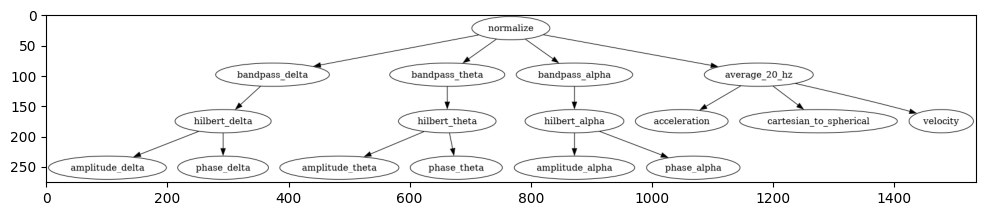

In [8]:
def fog_pipeline(fs):
    # define partial functions so that they only accepts arrays
    bandpass_delta = WrappedPartial(butter_bandpass_filter, lowcut=1, highcut=4, fs=fs).getfunc('bandpass_delta')
    bandpass_theta = WrappedPartial(butter_bandpass_filter, lowcut=4, highcut=8, fs=fs).getfunc('bandpass_theta')
    bandpass_alpha = WrappedPartial(butter_bandpass_filter, lowcut=8, highcut=16, fs=fs).getfunc('bandpass_alpha')
    average_20_hz = WrappedPartial(moving_average, window_size=fs//5).getfunc('average_20_hz')
    acceleration = WrappedPartial(lambda x : x).getfunc('acceleration')
    velocity = WrappedPartial(acceleration_to_velocity, fs=fs).getfunc('velocity')

    # define tuple-handing leaf-node functions for hilbert
    amplitude = lambda htup: htup[0] 
    phase = lambda htup: htup[1] 

    # Constructing a function tree, starting with normalization
    preproc_tree = FunctionNode(normalize)

    # Level 1 functions
    preproc_tree.add_child(bandpass_delta)
    preproc_tree.add_child(bandpass_theta)
    preproc_tree.add_child(bandpass_alpha)
    preproc_tree.add_child(average_20_hz)


    # Level 2 functions
    for band, child in zip(['delta', 'theta', 'alpha'],
                           [bandpass_delta, bandpass_theta, bandpass_alpha]):   
        hilbert_node = WrappedPartial(hilbert_transform).getfunc('hilbert_'+band)
        preproc_tree.add_child_to_node(child, hilbert_node)
    #     Level 3 functions
        preproc_tree.add_child_to_node(hilbert_node, WrappedPartial(amplitude).getfunc('amplitude_'+band))
        preproc_tree.add_child_to_node(hilbert_node, WrappedPartial(phase).getfunc('phase_'+band))
    preproc_tree.add_child_to_node(average_20_hz,acceleration)
    preproc_tree.add_child_to_node(average_20_hz, cartesian_to_spherical)
    preproc_tree.add_child_to_node(average_20_hz, velocity)
    return preproc_tree

preproc_tree = fog_pipeline(fs=128)
# Visualize the tree
graph = preproc_tree.visualize(size=('16,9'))
graph.render(filename='function_tree', directory='.', cleanup=True)
img = mpimg.imread('function_tree.png')
plt.figure(figsize=(12, 5))
imgplot = plt.imshow(img)
plt.show()

# 2. Preprocess and transform all training data

In [9]:
# raise

def prepare_fog_traning(sessions_dir, session_ids, fs, window_size, stride):

    X_all = []
    y_all = []
    preproc_tree = fog_pipeline(fs=fs)

    for session_id in tqdm(session_ids):
        df = pd.read_csv(sessions_dir / '{}.csv'.format(session_id))
        x_arr = df[['AccV','AccML', 'AccAP']].to_numpy().T
        y_arr = df[['StartHesitation', 'Turn', 'Walking']].to_numpy().T
        if 'Valid' in df.columns:
            mask = np.all(df[['Valid', 'Task']].to_numpy(), axis=1)
            x_arr = x_arr[:, mask]
            y_arr = y_arr[:, mask]
        if np.sum(y_arr) == 0:
            continue
        del df
        gc.collect()
        x_arr = preproc_tree.evaluate(x_arr)
        x_arr = x_arr.reshape((x_arr.shape[0]*x_arr.shape[1], -1))
        X_all.append(x_arr.T)
        del x_arr
        gc.collect()
        y_all.append(y_arr.T)
        del y_arr
        gc.collect()
    
    X_train = []
    y_train = []
    
    for x_long, y_long in zip(X_all, y_all): 
        for x, y in generate_shorter_sequences(x_long, y_long, window_size, stride):
            X_train.append(x)
            y = np.hstack([y, ~np.any(y, axis=1)[..., None]])
            y_train.append(y)
        
    X_train, y_train = np.array(X_train), np.array(y_train)
        
    return X_train, y_train
    

In [10]:
X_train_tdcsfog, y_train_tdcsfog = prepare_fog_traning(tdcsfog_train_dir, tdcsfog_train_sessions, fs=128, window_size=3406, stride=128*10)
X_train_defog, y_train_defog = prepare_fog_traning(defog_train_dir, defog_train_sessions, fs=100, window_size=100*60, stride=100*50)

  0%|          | 0/833 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

# 3. Train the models

## 3.1. Set up

### 3.1.1. Training config

In [11]:
# Define the weights for different classes in the loss function
loss_weights_tdcsfog = [2, 1, 1, 0.1]
loss_weights_defog = [5, 1, 4, 0.1]

# Determine the shape of the input data
input_shape_tdcs = (np.shape(X_train_tdcsfog)[-2], np.shape(X_train_tdcsfog)[-1])
input_shape_defog = (np.shape(X_train_defog)[-2], np.shape(X_train_defog)[-1])

# Define the optimizer with a specific learning rate
optimizer_tdcsfog = keras.optimizers.Adam(learning_rate=0.01)
optimizer_defog = keras.optimizers.Adam(learning_rate=0.01)

# Define a learning rate scheduler to adjust the learning rate based on validation loss
sheduler_tdcsfog = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1)
sheduler_defog = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1)

# Define early stopping to prevent overfitting by monitoring validation loss
early_stopping_tdcsfog = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')
early_stopping_defog = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')

# Define the neural network model architecture

model_tdcsfog = ResidualLSTM(num_layers=6, hidden_units=32, input_shape=input_shape_tdcs, output_size=4)
model_defog = ResidualLSTM(num_layers=6, hidden_units=32, input_shape=input_shape_defog, output_size=4)

# Define a CSV logger to log training history to a file
csv_logger_tdcsfog = CSVLogger("/kaggle/working/model_history_log_tdcsfog.csv", append=True)
csv_logger_defog = CSVLogger("/kaggle/working/model_history_log_defog.csv", append=True)

# Compile the model with specified optimizer, loss function, and metrics
model_tdcsfog.compile(
    optimizer=optimizer_tdcsfog,
    loss='categorical_crossentropy',  # Categorical crossentropy loss function
    loss_weights=loss_weights_tdcsfog,  # Apply class weights to the loss function
    weighted_metrics=['categorical_accuracy'],# Use weighted accuracy as a metric
    metrics=[tf.keras.metrics.Precision(class_id=0),
            tf.keras.metrics.Precision(class_id=1),
            tf.keras.metrics.Precision(class_id=2),
            tf.keras.metrics.Recall(class_id=0),
            tf.keras.metrics.Recall(class_id=1),
            tf.keras.metrics.Recall(class_id=2)
            ]
)
model_defog.compile(
    optimizer=optimizer_defog,
    loss='categorical_crossentropy',  # Categorical crossentropy loss function
    loss_weights=loss_weights_defog,  # Apply class weights to the loss function
    weighted_metrics=['categorical_accuracy'],# Use weighted accuracy as a metric
    metrics=[tf.keras.metrics.Precision(class_id=0),
            tf.keras.metrics.Precision(class_id=1),
            tf.keras.metrics.Precision(class_id=2),
            tf.keras.metrics.Recall(class_id=0),
            tf.keras.metrics.Recall(class_id=1),
            tf.keras.metrics.Recall(class_id=2)
            ]
)



### 3.1.2. Data preparation

In [12]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Define the validation split ratio
val_split = 0.1

# Calculate the number of samples for validation
val_samples_tdcsfog = int(len(X_train_tdcsfog) * val_split)
val_samples_defog = int(len(X_train_defog) * val_split)

# Randomly select samples for validation from the entire dataset
val_id_tdcsfog = np.random.choice(len(X_train_tdcsfog), val_samples_tdcsfog, replace=False)
val_id_defog = np.random.choice(len(X_train_defog), val_samples_defog, replace=False)

# Create training and validation datasets using indices
train_id_tdcsfog = np.setdiff1d(np.arange(len(X_train_tdcsfog)), val_id_tdcsfog)
train_dataset_tdcsfog = tf.data.Dataset.from_tensor_slices((X_train_tdcsfog[train_id_tdcsfog], y_train_tdcsfog[train_id_tdcsfog]))
val_dataset_tdcsfog = tf.data.Dataset.from_tensor_slices((X_train_tdcsfog[val_id_tdcsfog], y_train_tdcsfog[val_id_tdcsfog]))

train_id_defog = np.setdiff1d(np.arange(len(X_train_defog)), val_id_defog)
train_dataset_defog = tf.data.Dataset.from_tensor_slices((X_train_defog[train_id_defog], y_train_defog[train_id_defog]))
val_dataset_defog = tf.data.Dataset.from_tensor_slices((X_train_defog[val_id_defog], y_train_defog[val_id_defog]))

# Define the batch size
batch_size = 32

# Shuffle and batch the training dataset
train_dataset_tdcsfog = train_dataset_tdcsfog.shuffle(buffer_size=len(train_id_tdcsfog),
                                      seed=SEED).batch(batch_size)
train_dataset_defog = train_dataset_defog.shuffle(buffer_size=len(train_id_defog),
                                      seed=SEED).batch(batch_size)

# Batch the validation dataset
val_dataset_tdcsfog = val_dataset_tdcsfog.batch(batch_size)
val_dataset_defog = val_dataset_defog.batch(batch_size)

## 3.2. Training routine

In [13]:
history_tdcsfog = model_tdcsfog.fit(
    train_dataset_tdcsfog,
    epochs=200,
    validation_data=val_dataset_tdcsfog,
    verbose=1,
    callbacks=[early_stopping_tdcsfog, sheduler_tdcsfog, csv_logger_tdcsfog],
    use_multiprocessing=True
)

# Store training history as a dataframe
history_df_tdcsfog = pd.DataFrame(history_tdcsfog.history)

Epoch 1/200
89/89 [==============================] - 57s 491ms/step - loss: 2.1942 - precision: 0.3798 - precision_1: 0.6027 - precision_2: 0.0903 - recall: 0.2228 - recall_1: 0.4996 - recall_2: 0.0256 - categorical_accuracy: 0.6132 - val_loss: 1.4395 - val_precision: 0.7991 - val_precision_1: 0.7545 - val_precision_2: 0.7272 - val_recall: 0.3604 - val_recall_1: 0.4840 - val_recall_2: 0.0703 - val_categorical_accuracy: 0.7159 - lr: 0.0100
Epoch 2/200
89/89 [==============================] - 42s 459ms/step - loss: 1.4810 - precision: 0.5909 - precision_1: 0.6946 - precision_2: 0.4818 - recall: 0.3209 - recall_1: 0.6110 - recall_2: 0.0752 - categorical_accuracy: 0.6972 - val_loss: 1.5944 - val_precision: 0.4154 - val_precision_1: 0.6937 - val_precision_2: 0.8985 - val_recall: 0.1096 - val_recall_1: 0.5999 - val_recall_2: 0.1144 - val_categorical_accuracy: 0.7062 - lr: 0.0100
Epoch 3/200
89/89 [==============================] - 42s 455ms/step - loss: 1.5334 - precision: 0.6066 - precision

In [14]:
history_defog = model_defog.fit(
    train_dataset_defog,
    epochs=200,
    validation_data=val_dataset_defog,
    verbose=1,
    callbacks=[early_stopping_defog, sheduler_defog, csv_logger_defog],
    use_multiprocessing=True
)

# Store training history as a dataframe
history_df_defog = pd.DataFrame(history_defog.history)

Epoch 1/200
24/24 [==============================] - 34s 941ms/step - loss: 25.3360 - precision_3: 2.0974e-05 - precision_4: 0.1733 - precision_5: 0.0334 - recall_3: 0.0072 - recall_4: 0.1099 - recall_5: 0.1354 - categorical_accuracy: 0.6600 - val_loss: 12.1363 - val_precision_3: 0.0000e+00 - val_precision_4: 0.1759 - val_precision_5: 0.0704 - val_recall_3: 0.0000e+00 - val_recall_4: 0.3826 - val_recall_5: 0.0054 - val_categorical_accuracy: 0.7061 - lr: 0.0100
Epoch 2/200
24/24 [==============================] - 20s 828ms/step - loss: 6.5220 - precision_3: 0.0000e+00 - precision_4: 0.2769 - precision_5: 0.0174 - recall_3: 0.0000e+00 - recall_4: 0.2121 - recall_5: 0.0056 - categorical_accuracy: 0.7662 - val_loss: 4.9880 - val_precision_3: 0.0000e+00 - val_precision_4: 0.3000 - val_precision_5: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.4062 - val_recall_5: 0.0000e+00 - val_categorical_accuracy: 0.8048 - lr: 0.0100
Epoch 3/200
24/24 [==============================] - 20s 836

# 4. Submission

## 4.1. Preprocess the test set

In [15]:
del train_dataset_tdcsfog, train_dataset_defog, val_dataset_tdcsfog, val_dataset_defog, X_train_tdcsfog, y_train_tdcsfog, X_train_defog, y_train_defog
gc.collect()

78

In [16]:
def prepare_fog_testing(sessions_dir, session_ids, fs, window_size, stride):
    X_all = []
    X_ids = []
    preproc_tree = fog_pipeline(fs=fs)

    for session_id in tqdm(session_ids):
        df = pd.read_csv(sessions_dir / '{}.csv'.format(session_id))
        id_time = [f'{session_id}_{t}' for t in range(len(df))]
        X_ids.append(np.array(id_time)[..., None])
        x_arr = df[['AccV','AccML', 'AccAP']].to_numpy().T
        if 'Valid' in df.columns:
            mask = np.all(df[['Valid', 'Task']].to_numpy(), axis=1)
            x_arr = x_arr[:, mask]
        del df
        gc.collect()
        x_arr = preproc_tree.evaluate(x_arr)
        x_arr = x_arr.reshape((x_arr.shape[0]*x_arr.shape[1], -1))
        X_all.append(x_arr.T)
        del x_arr
        gc.collect()
    
    X_test = []
    X_id_time = []
    
    for x_long, id_long in zip(X_all, X_ids): 
        for x, i in generate_shorter_sequences(x_long, id_long, window_size, stride):
            X_test.append(x)
            X_id_time.append(i)
            
        
    X_test, X_id_time = np.array(X_test), np.array(X_id_time)
    if X_test.ndim == 2:
        X_test = X_test[None, ...]
        
    return X_test, X_id_time


def create_template(ids, example=sample_submission):
    template = pd.DataFrame(np.zeros((len(ids), 4)), columns=sample_submission.columns)
    template['Id'] = ids
    return template


def populate_submission(model, test_dataset, template):
    for batch, id_batch in test_dataset:
        pred = model.predict(batch, verbose=1, use_multiprocessing=True)
        for seqi, id_single in enumerate(id_batch):
            first_id = id_single[0]
            first_id = tf.compat.as_str_any(first_id.numpy()[0])
            last_id = id_single[-1]
            last_id = tf.compat.as_str_any(last_id.numpy()[0])
            
            first_loc = template.loc[template['Id']==first_id].index.tolist()[0]
            last_loc = template.loc[template['Id']==last_id].index.tolist()[0]
              
            template.iloc[first_loc:last_loc+1, 1:] = pred[seqi, :, :-1]
    return template

In [17]:
ids = []
for session in tqdm(tdcsfog_test_sessions):
    df = pd.read_csv(tdcsfog_test_dir / '{}.csv'.format(session))
    this_ids = [str(session)+'_'+str(t) for t in range(len(df))]
    ids = ids + this_ids
        
for session in tqdm(defog_test_sessions):
    df = pd.read_csv(defog_test_dir / '{}.csv'.format(session))
    this_ids = [str(session)+'_'+str(t) for t in range(len(df))]
    ids = ids + this_ids
        
template = create_template(ids)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
submission = None
for session in tdcsfog_test_sessions:
    X_test_tdcsfog, X_test_tdcsfog_idt = prepare_fog_testing(tdcsfog_test_dir, [session], fs=128, window_size=3406, stride=128*24)
    X_test_dataset_tdcsfog = tf.data.Dataset.from_tensor_slices((X_test_tdcsfog, X_test_tdcsfog_idt)).batch(32)
    test_df_tdcsfog = populate_submission(model_tdcsfog, X_test_dataset_tdcsfog, template)
    del test_df_tdcsfog
    gc.collect()

for session in defog_test_sessions:
    X_test_defog, X_test_defog_idt = prepare_fog_testing(defog_test_dir, [session], fs=100, window_size=100*60, stride=100*58)
    X_test_dataset_defog = tf.data.Dataset.from_tensor_slices((X_test_defog, X_test_defog_idt)).batch(32)
    test_df_defog = populate_submission(model_defog, X_test_dataset_defog, template)
    del test_df_defog
    gc.collect()
    
template.to_csv('submission.csv', index=False)
template

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0.056076,0.341786,0.160329
1,003f117e14_1,0.037744,0.122427,0.023061
2,003f117e14_2,0.016702,0.021882,0.003197
3,003f117e14_3,0.012668,0.011050,0.002325
4,003f117e14_4,0.006397,0.009314,0.001140
...,...,...,...,...
286365,02ab235146_281683,0.000029,0.016986,0.003316
286366,02ab235146_281684,0.000041,0.022665,0.004331
286367,02ab235146_281685,0.000050,0.026311,0.005072
286368,02ab235146_281686,0.000047,0.024389,0.005170


In [19]:
# model.save('/kaggle/working/exp4_lstm/')
# import shutil
# shutil.make_archive('exp3_lstm', 'zip', '/kaggle/working/exp4_lstm/')

# Scratchpad

# Pure data

In [20]:
# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
#         mask_event = np.argwhere(sample_df[event].to_numpy().astype(bool)).ravel()
#         timeseries_event = sample_df[column]
#         sum_acc = timeseries_event.sum()
#         timepoints = np.arange(len(timeseries_event))
#         mean_acc = timepoints[mask_event].mean()
#         plt.plot(timepoints[mask_event] / 128, timeseries_event[mask_event], color=color, label=event+', mean acc = {:.4f}'.format(mean_acc))
#         plt.title(column)
#         plt.legend()

In [21]:
# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# window_size = 128 * 4
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
#         mask_event = np.argwhere(sample_df[event].to_numpy().astype(bool)).ravel()
#         timeseries_event = sample_df[column]
#         sum_acc = timeseries_event.sum()
#         timepoints = np.arange(len(timeseries_event))
#         x =  timepoints[mask_event]
#         y = timeseries_event[mask_event].rolling(window=window_size).mean()
#         plt.plot(x / 128, y, color=color, label=event)
#         plt.title(column)
#         plt.legend()

# 

# Spherical

In [22]:
# sf = 128
# start, stop = 5, 500 # seconds
# start_bin, stop_bin = start * sf, stop * sf
# sample_subject = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_subject))

# r_list = []
# theta_list = []
# phi_list = []

# # compute the radial distance, azimuth angle, polar angle
# for vector in sample_df[['AccV','AccML', 'AccAP']].to_numpy():
#     r, theta, phi = cartesian_to_spherical(*vector)
#     r_list.append(r)
#     theta_list.append(theta)
#     phi_list.append(phi)

# for name, unit, feature in zip(['vector norm', 'polar angle', 'azimuth angle'],
#                                ['G', 'radian', 'radian'],
#                          [np.array(r_list), np.array(theta_list), np.array(phi_list)]):
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
#         mask_event = sample_df[event].to_numpy().astype(bool)
#         timeseries_event = feature
#         timepoints = np.arange(len(timeseries_event))
#         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
#         mask = epoch_mask & mask_event
#         plt.plot(timepoints[mask] / 128, timeseries_event[mask], color=color, label=event)
#         plt.title(name)
#         plt.ylabel(unit)
#         plt.legend()

## Correlation between cartesian and spherical accelerations

In [23]:
# accelerations = sample_df[['AccV','AccML', 'AccAP']].to_numpy()
# for ft in [r_list, theta_list, phi_list]:
#     ft = np.array(ft)[..., None]
#     accelerations = np.hstack([accelerations, ft])
    
# print(np.corrcoef(accelerations.T))
# # accelerations.shape
    

# Speed

In [24]:
# sf = 128
# start, stop = 0, 500 # seconds
# start_bin, stop_bin = start * sf, stop * sf

# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
        
# #         mask_event = sample_df[event].to_numpy().astype(bool)
# #         timeseries_event = feature
# #         timepoints = np.arange(len(timeseries_event))
# #         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
# #         mask = epoch_mask & mask_event
        
#         mask_event = sample_df[event].to_numpy().astype(bool)
#         timeseries_event = np.cumsum(sample_df[column])
#         timepoints = np.arange(len(timeseries_event))
#         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
#         mask = epoch_mask & mask_event
#         plt.plot(timepoints[mask] / 128, timeseries_event[mask], color=color, label=event)
#         plt.title(column)
#         plt.ylim(-500000, 500000)
#         plt.legend()

# Jerk

In [25]:
# sf = 128
# start, stop = 0, 500 # seconds
# start_bin, stop_bin = start * sf, stop * sf

# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
        
# #         mask_event = sample_df[event].to_numpy().astype(bool)
# #         timeseries_event = feature
# #         timepoints = np.arange(len(timeseries_event))
# #         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
# #         mask = epoch_mask & mask_event
        
#         mask_event = sample_df[event].to_numpy().astype(bool)[1:]
#         timeseries_event = np.diff(sample_df[column])
#         timepoints = np.arange(len(timeseries_event))
#         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
#         mask = epoch_mask & mask_event
#         plt.plot(timepoints[mask] / 128, timeseries_event[mask], color=color, label=event)
#         plt.title(column)
# #         plt.ylim(-500000, 500000)
#         plt.legend()

# Spectrogram

In [26]:
# sf = 128
# start, stop = 0, 500 # seconds
# start_bin, stop_bin = start * sf, stop * sf

# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
        
# #         mask_event = sample_df[event].to_numpy().astype(bool)
# #         timeseries_event = feature
# #         timepoints = np.arange(len(timeseries_event))
# #         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
# #         mask = epoch_mask & mask_event
        
#         mask_event = sample_df[event].to_numpy().astype(bool)[1:]
#         timeseries_event = np.diff(sample_df[column])
#         timepoints = np.arange(len(timeseries_event))
#         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
#         mask = epoch_mask & mask_event
#         plot_spectrogram(timeseries_event[mask], fs=100, maxfreq=50, minfreq=0)
# #         plt.plot(timepoints[mask] / 128, timeseries_event[mask], color=color, label=event)
#         plt.title(column + ' ' + event)
# # #         plt.ylim(-500000, 500000)
# #         plt.legend()

# Hilbert

In [27]:
# # Bandpass filter parameters
# lowcut = 1  # Lower cutoff frequency
# highcut = 5  # Higher cutoff frequency
# fs = 100  # Sampling frequency


# sf = 128
# start, stop = 0, 500 # seconds
# start_bin, stop_bin = start * sf, stop * sf

# sample_sessions = '76c7edf878'
# sample_df = pd.read_csv(tdcsfog_train_dir / '{}.csv'.format(sample_sessions))
# for column in ['AccV','AccML', 'AccAP']:
#     plt.figure(figsize=(10, 1))
#     for color, event in zip(['red', 'blue', 'green'], 
#                             ['StartHesitation', 'Turn', 'Walking']):
        
#         mask_event = sample_df[event].to_numpy().astype(bool)[1:]
#         timeseries_event = np.diff(sample_df[column])
#         timepoints = np.arange(len(timeseries_event))
#         epoch_mask = (start_bin <= timepoints) & (timepoints <= stop_bin)
#         mask = epoch_mask & mask_event
#         x = timepoints[mask] / 128
#         y = timeseries_event[mask]
#         fig, ax = plt.subplots(2, 1, sharex=True)
#         # Apply bandpass filter
#         filtered_data = butter_bandpass_filter(y, lowcut, highcut, fs)

#         # Compute Hilbert transform
#         analytic_signal = hilbert(filtered_data)
#         amplitude_envelope = np.abs(analytic_signal)
#         instantaneous_phase = np.angle(analytic_signal)
        
#         ax[0].plot(instantaneous_phase, color=color)
#         ax[0].set_title('Phase, '+event)
#         ax[1].plot(amplitude_envelope, color=color)
#         ax[1].set_title('Amplitude, '+event)
        
#         plt.title(column)
# #         plt.ylim(-500000, 500000)
#         plt.legend()